# Manual adaptation

This is an example of how to manually remove vertices and refine edges. With this, we can also implement an anisotropic refinement.

## Grid creation

We use the [horizontal](grids/horizontal.rst) grid file that contains an interface $\Gamma = [0.25, 0.75] \times {0.5}$ embedded in a domain $\Omega = [0,1]^2$.

In [1]:
from dune.grid import reader
from dune.mmesh import mmesh

from dune.fem.view import adaptiveLeafGridView as adaptive
from dune.fem import parameter, adapt
parameter.append( { "fem.adaptation.method": "callback" } )

dim = 2
file = "grids/horizontal.msh"

gridView  = adaptive( mmesh((reader.gmsh, file), dim) )
hgrid = gridView.hierarchicalGrid

## Interpolating some high order function

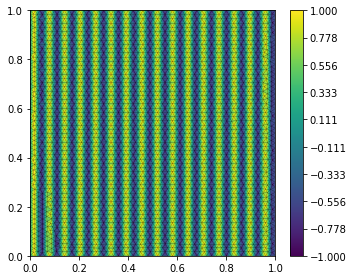

In [2]:
from ufl import *
from dune.fem.space import dglagrange as functionspace

space = functionspace(gridView, order=5)
x = SpatialCoordinate(space)

uh = space.interpolate( sin(100*x[0]), name="uh")
uh.plot()

## Removing and inserting vertices

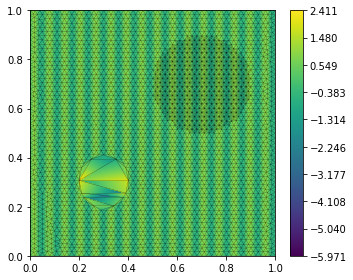

In [3]:
from dune.common import FieldVector

for v in gridView.vertices:
    if (v.geometry.center - FieldVector([0.3, 0.3])).two_norm < 0.1:
        hgrid.removeVertex(v)

for e in gridView.elements:
    if (e.geometry.center - FieldVector([0.7, 0.7])).two_norm < 0.2:
        hgrid.insertVertexInCell( e.geometry.center )

adapt([uh])
uh.plot()

## Refining edges

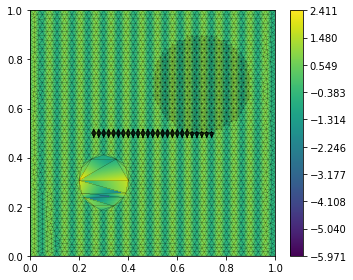

In [4]:
def myRefine():
    for e in gridView.elements:
        for i in gridView.intersections(e):
            if hgrid.isInterface(i):
                hgrid.refineEdge(e, i.indexInInside)

for i in range(5):
    myRefine()
    adapt([uh])            

uh.plot()